In [1]:
import scipy.io as scio
from scipy.io import savemat  # 把dict文件保存为mat文件
import numpy as np
from sklearn.metrics import r2_score
import lightgbm as lgb
import shap
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\马明杰\AppData\Local\Programs\Python\Python39\lib\site-packages\dask\dataframe\__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## 导入数据

In [2]:
# 导入数据
data_train=scio.loadmat("E:\论文2\综合长势\训练集与测试集\matlab.mat")

# 训练集的输入和输出
data_train_x=data_train['data_Oriny_prey']['train_X'][0,0]
data_train_y=data_train['data_Oriny_prey']['train_y'][0,0]

# 验证集的输入和输出
#data_vaild_x=data_train['data_Oriny_prey']['vaild_X'][0,0]
#data_vaild_y=data_train['data_Oriny_prey']['vaild_y'][0,0]

# 测试集的输入和输出
data_test_x=data_train['data_Oriny_prey']['test_X'][0,0]
data_test_y=data_train['data_Oriny_prey']['test_y'][0,0]


# 标准化 Zscore 标准化
X_mean, y_mean = data_train_x.mean(0), data_train_y.mean(0)
X_std, y_std = data_train_x.std(0), data_train_y.std(0)

data_train_x_nor = (data_train_x - X_mean) / X_std  
#data_vaild_x_nor = (data_vaild_x - X_mean) / X_std
data_test_x_nor = (data_test_x - X_mean) / X_std

data_train_y_nor = (data_train_y - y_mean) / y_std  
data_vaild_y_nor = (data_test_y - y_mean) / y_std
#data_test_y_nor = (data_vaild_y - y_mean) / y_std

In [3]:
# 指定评价函数
# 和工具箱的5个指标是一样的

def evaluate_regress(y_pre, y_true):
   
    MAE=np.sum(np.abs(y_pre-y_true))/len(y_true)
    print('MAE为: ',str(MAE))

    MAPE=np.sum(np.abs((y_pre-y_true)/y_true))/len(y_true)
    print('MAPE为: ',str(MAPE))

    MSE=np.sum((y_pre-y_true) ** 2)/len(y_true)
    print('MSE为: ',str(MSE))
    
    RMSE=np.sqrt(MSE)
    print('RMSE为: ',str(RMSE))

    R2=r2_score(y_true, y_pre)
    print('R2为: ',str(R2))

    return MAE,MAPE,MSE,RMSE,R2

# MAE,MAPE,MSE,RMSE,R2=evaluate_regress(data_test_prey, data_test_y)

## 模型训练

In [4]:

#  非常详细的lightbgm
#  https://jmarkhou.com/lgbqr/

quantile = 0.5  # 中位数

model_lgb = lgb.train({'objective': 'quantile', 'alpha': quantile,'force_col_wise': True,}, 
                          lgb.Dataset(data_train_x_nor, data_train_y_nor), num_boost_round=1800)

y_pred_test_nor=model_lgb.predict(data_test_x_nor)
y_pred_train_nor=model_lgb.predict(data_train_x_nor)    
#y_pred_vaild_nor=model_lgb.predict(data_vaild_x_nor)

y_pred_test=y_pred_test_nor*y_std+y_mean
y_pred_test1=y_pred_test.reshape(len(y_pred_test),1)
data_test_y=data_test_y.reshape(len(data_test_y),1)
y_pred_train=y_pred_train_nor*y_std+y_mean
y_pred_train1=y_pred_train.reshape(len(y_pred_train),1)

#y_pred_vaild=y_pred_vaild_nor*y_std+y_mean
#y_pred_vaild1=y_pred_vaild.reshape(len(y_pred_vaild),1)

MAE,MAPE,MSE,RMSE,R2=evaluate_regress(y_pred_test1,data_test_y )

data_Oriny_pre={}
data_Oriny_pre['y_train_predict']=y_pred_train1
#data_Oriny_pre['y_vaild_predict']=y_pred_vaild1
data_Oriny_pre['y_test_predict']=y_pred_test1

# savemat('训练结果 lightgbm_predict.mat', data_Oriny_pre)


C:\Users\马明杰\AppData\Local\Programs\Python\Python39\lib\site-packages\lightgbm\basic.py:355: UserWarning: Converting column-vector to 1d array
  _log_warning("Converting column-vector to 1d array")


[LightGBM] [Info] Total Bins 2543
[LightGBM] [Info] Number of data points in the train set: 800, number of used features: 10
[LightGBM] [Info] Start training from score 0.497367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [5]:
#feature_label=['crim','zn','chas','nox','rm','dis','rad','ptratio','b','lstat']
feature_label=['B3','B4','B11','CL','GNDVI','IPVI','NDVI','NDWI','RDVI','RVI']

data_train_x_nor1= pd.DataFrame(data_train_x_nor,columns=feature_label)

#提取原值
data_train_x_2= pd.DataFrame(data_train_x,columns=feature_label)
data_test_x_2= pd.DataFrame(data_test_x,columns=feature_label)



data_train_x_nor1
data_train_x_2
data_test_x_2

B3      B4     B11        CL     GNDVI      IPVI      NDVI      NDWI  \
0    0.2826  0.3100  0.3937  0.372258  0.156921  0.555747  0.111493 -0.007550   
1    0.2686  0.2928  0.3686  0.381236  0.160100  0.558903  0.117806  0.003245   
2    0.2734  0.2982  0.3700  0.364301  0.154084  0.555721  0.111442  0.004038   
3    0.2634  0.2826  0.3647  0.384207  0.161146  0.563350  0.126700 -0.000137   
4    0.2594  0.2788  0.3663  0.434079  0.178334  0.571604  0.143208  0.007720   
..      ...     ...     ...       ...       ...       ...       ...       ...   
196  0.1583  0.1455  0.2584  1.976627  0.497061  0.764067  0.528134  0.291667   
197  0.1611  0.1467  0.2582  1.912477  0.488815  0.761812  0.523624  0.290074   
198  0.1577  0.1473  0.2564  1.934686  0.491700  0.758564  0.517128  0.286986   
199  0.1608  0.1451  0.2596  1.935323  0.491783  0.764868  0.529736  0.290322   
200  0.1600  0.1471  0.2626  1.940000  0.492386  0.761781  0.523563  0.283492   

         RDVI       RVI  
0    0.093135  1.250968  
1    0.095982  1.267076  
2    0.091301  1.250838  
3    0.101928  1.290163  
4    0.115529  1.334290  
..        ...       ...  
196  0.414745  3.238488  
197  0.410936  3.198364  
198  0.403923  3.141887  
199  0.416138  3.252929  
200  0.411422  3.197825  

[201 rows x 10 columns]

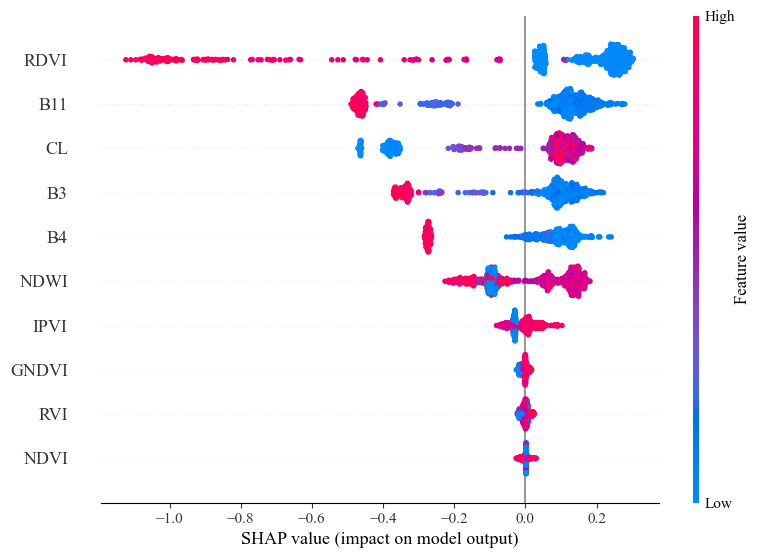

In [6]:
# 创建SHAP解释器
explainer = shap.TreeExplainer(model_lgb)

# 计算SHAP值
shap_values = explainer.shap_values(data_train_x_nor)

#特征标签
#feature_label=['crim','zn','chas','nox','rm','dis','rad','ptratio','b','lstat']
feature_label=['B3','B4','B11','CL','GNDVI','IPVI','NDVI','NDWI','RDVI','RVI']
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 4  # 设置字体大小为14
# 现在创建 SHAP 可视化 

#配色   viridis  Spectral   coolwarm  RdYlGn  RdYlBu  RdBu  RdGy  PuOr  BrBG PRGn  PiYG 
shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label)

#粉红色点：表示该特征值在这个观察中对模型预测产生了正面影响（增加预测值）
#蓝色点：表示该特征值在这个观察中对模型预测产生了负面影响（降低预测值）
#水平轴（SHAP 值）显示了影响的大小。点越远离中心线（零点），该特征对模型输出的影响越大
#图中垂直排列的特征按影响力从上到下排序。上方的特征对模型输出的总体影响更大，而下方的特征影响较小。
# 最上方的特征（例如 "lstat"）显示了大量的正面和负面影响，表明它在不同的观察值中对模型预测的结果有很大的不同影响。
# 中部的特征（如 "rm" 和 "dis"）也显示出两种颜色的点，但点的分布更集中，影响相对较小。
# 底部的特征（如 "chas" 和 "zn"）对模型的影响最小，且大部分影响较为接近零，表示这些特征对模型预测的贡献较小

In [7]:
print(shap_values.shape)
print(data_train_x_nor.shape)

(800, 10)
(800, 10)


In [8]:
shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,plot_type='bar')
#主要表示绝对重要值的大小，把SHAP value 的样本取了绝对平均值
# 房价预测模型中，lstat（较低状态人口的百分比）和 rm（住宅平均房间数）可能是影响房价的关键因素

In [9]:

# 直接导出数据画图会自由很多
mean_shap_values = np.abs(shap_values).mean(axis=0)  
features = feature_label
df = pd.DataFrame({'feature_label': feature_label, 'mean_shap_values': mean_shap_values})
with pd.ExcelWriter(r"E:\论文2\综合长势\训练集与测试集\shap值.xlsx") as writer:
    df.to_excel(writer, sheet_name='Sheet1', index=False)
    #writer.save()
# 绘制柱状图
plt.bar(features, mean_shap_values, color='green')  # 可以指定任意颜色
plt.xticks(rotation=90)
plt.title('Feature Importance')
plt.show()


In [10]:
# 创建SHAP解释器
explainer = shap.TreeExplainer(model_lgb)

# 计算SHAP值
shap_values = explainer.shap_values(data_train_x_nor1)


#特征标签
shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,show=False)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 24  # 设置字体大小为14
# 现在创建 SHAP 可视化 

#配色   viridis  Spectral   coolwarm  RdYlGn  RdYlBu  RdBu  RdGy  PuOr  BrBG PRGn  PiYG  RdYlBu
shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,cmap='RdBu')


# 显示图形

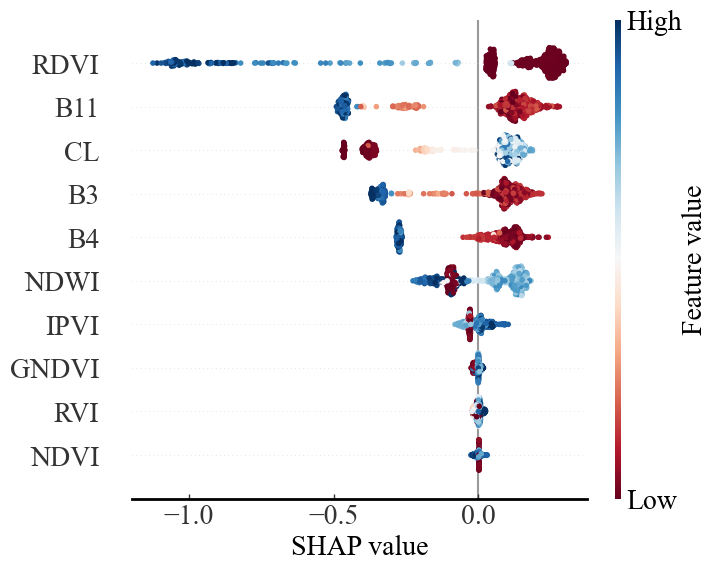

In [11]:
# 导出高质量的图片
# 创建SHAP解释器
explainer = shap.TreeExplainer(model_lgb)

# 计算SHAP值
shap_values = explainer.shap_values(data_train_x_nor)

# 可视化SHAP值

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20  # 设置字体大小为12  
# 现在创建 SHAP 可视化
#配色   viridis  #配色   viridis  Spectral   coolwarm  RdYlGn  RdYlBu  RdBu  RdGy  PuOr  BrBG PRGn  PiYG   
shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,cmap='RdBu',show=False)


#------------------------------------SHAP value-------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize=20)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
colorbar.set_label('Feature value')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(20)  # 设置colorbar标题的字体大小 
colorbar.yaxis.label.set_color('black')  # 设置colorbar标题的颜色为黑色
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 修改colorbar的颜色  
for label in colorbar.get_yticklabels():  
    label.set_color('black')  # 将colorbar标签颜色设置为黑色  



plt.gcf().set_size_inches(7, 6)
# 修改X轴标题  
plt.xlabel('SHAP value',fontsize=20) 
# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5   2磅
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=1)  # direction='in'表示向内  
# 调整X轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=20)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=20)  # labelsize设置字体大小
# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=20, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#        

# 保存图形为高质量的图片文件
plt.savefig('shap value.png', dpi=300, bbox_inches='tight')

# 显示图形

In [70]:
# 设置字体为新罗马并调整字体大小======NDVI-RDVI==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman

# 创建 SHAP dependence plot，并修改配色方案为 'RdBu' 

#  ['B3','B4','B11','CL','GNDVI','IPVI','NDVI','NDWI','RDVI','RVI']
#CL 
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('RVI', shap_values, data_train_x_2, interaction_index='RDVI',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']

#shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,show=False)

#--------------------------------------VV--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
colorbar.yaxis.label.set_color('black')  # 设置colorbar标题的颜色为黑色
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  


#colorbar刻度向内
colorbar.tick_params(direction='in')

 
 


colorbar.set_aspect(20) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(B11)',fontsize=30) 
plt.xlabel('B11',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度     
plt.xticks(ticks=[0.25, 0.25, 0.45, 0.65], labels=['0.05','0.25', '0.45','0.65'])  
plt.yticks(ticks=[-0.40, -0.05, 0.10, 0.45], labels=['-0.20', '-0.05', '0.10', '0.25'])    

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  


#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('NDVI-VHs.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 
#解释
# 负相关关系：lstat 对模型预测有显著的负面影响。高 lstat 值显著降低了预测值。也就是说，随着 lstat 的增加，目标变量 b 的预测值逐渐降低。
# 影响的程度：lstat 的值在 0 到 2 的范围内，SHAP 值有较大的变化。这表明，在这个范围内，lstat 对模型预测的影响最大。

# 特征重要性：这个图显示了 lstat 是一个对模型预测非常重要的特征。理解 lstat 对预测的具体影响有助于进一步优化模型，或者在数据预处理中针对性地处理 lstat 的数据。
# 模型优化：通过这种依赖性图，可以更好地理解模型对特定特征值范围的敏感性，从而可以在这些范围内进行更精细的数据采集和模型调整

In [13]:
# 设置字体为新罗马并调整字体大小======VHs/VVs-NDVI==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('VHs/VVs', shap_values, data_train_x_2, interaction_index='NDVI',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
#--------------------------------------VH--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  

#colorbar刻度向内
colorbar.tick_params(direction='in')

colorbar.set_aspect(160) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(VHs/VVs)',fontsize=30) 
plt.xlabel('VHs/VVs',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度  
plt.xticks(ticks=[1.2, 1.4, 1.6, 1.8, 2.0], labels=['1.2','1.4', '1.6','1.8','2,0'])  
plt.yticks(ticks=[-0.20, -0.10,0.00, 0.10, 0.20], labels=['-0.20', '-0.10', '0.00','0.10', '0.20'])  

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('N-NDVI.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 

In [387]:
# 设置字体为新罗马并调整字体大小======VHs-NDVI==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('VHs', shap_values, data_train_x_2, interaction_index='NDVI',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
#--------------------------------------VH--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  

#colorbar刻度向内
colorbar.tick_params(direction='in')

colorbar.set_aspect(160) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(VVs)',fontsize=30) 
plt.xlabel('VHs',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度  
plt.xticks(ticks=[-20, -18, -16, -14, -12], labels=['-20','-18', '-16','-14','-12'])  
plt.yticks(ticks=[-0.40, -0.20,0.00, 0.20, 0.40], labels=['-0.40', '-0.20', '0.00','0.20', '0.40'])  

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('VHs-NDVI.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 

In [388]:
# 设置字体为新罗马并调整字体大小======VVs-NDVI==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('VVs', shap_values, data_train_x_2, interaction_index='NDVI',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
#--------------------------------------VH--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  

#colorbar刻度向内
colorbar.tick_params(direction='in')

colorbar.set_aspect(160) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(VVs)',fontsize=30) 
plt.xlabel('VVs',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度  
plt.xticks(ticks=[-15, -13, -11, -9, -7], labels=['-15','-13', '-11','-9','-7'])  
plt.yticks(ticks=[-0.60, -0.30,0.00, 0.30, 0.60], labels=['-0.60', '-0.30', '0.00','0.30', '0.60'])  

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('VVs-NDVI.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 

In [389]:
# 设置字体为新罗马并调整字体大小======VV-NDVI==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('VV', shap_values, data_train_x_2, interaction_index='NDVI',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
#--------------------------------------VH--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  

#colorbar刻度向内
colorbar.tick_params(direction='in')

colorbar.set_aspect(160) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(VV)',fontsize=30) 
plt.xlabel('VV',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度  
plt.xticks(ticks=[-15, -13, -11, -9, -7], labels=['-15','-13', '-11','-9','-7'])  
plt.yticks(ticks=[-0.25, -0.10,0.05, 0.20, 0.35], labels=['-0.25', '-0.10', '0.05','0.20', '0.35'])  

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('VV-NDVI.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 

In [390]:
# 设置字体为新罗马并调整字体大小======VH-VHs==========
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 30 # 设置字体大小为14 SimSun Times New Roman
# shap.dependence_plot('Feature 1', shap_values, data_train_x_nor, interaction_index='Feature 2')
#shap.dependence_plot('lstat', shap_values, data_train_x_nor1, interaction_index='b')
shap.dependence_plot('VH', shap_values, data_train_x_2, interaction_index='VHs',show=False)#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
#--------------------------------------VH--VVs-----------------------------------------------------------
# 获取当前图形的colorbar  
colorbar = plt.gcf().get_axes()[1]  
colorbar.tick_params(labelsize= 30)  # 调整colorbar的标签字体大小  

# 调整colorbar的标题和字体大小  
#colorbar.set_label('0')  # 设置colorbar的标题  
colorbar.yaxis.label.set_fontsize(30)  # 设置colorbar标题的字体大小 
#colorbar.set_label('Feature value', fontsize=16)  # 设置colorbar的标题和字体大小

# 调整colorbar与X轴的距离  
#colorbar.yaxis.set_label_coords(12.15, 0.5)  # 调整colorbar标题的位置  

#colorbar刻度向内
colorbar.tick_params(direction='in')

colorbar.set_aspect(20) #VHs/VVs=180; NDVI=160/180; VV=15; VVs=18; VH/s=20
    
plt.gcf().set_size_inches(7, 6)
# 修改Xy轴标题  
plt.ylabel('SHAP value(VH)',fontsize=30) 
plt.xlabel('VH',fontsize=30) 

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(2)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in', width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', direction='in', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=30)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=30)  # labelsize设置字体大小

# 设置XY轴坐标刻度  
plt.xticks(ticks=[-22, -19, -16, -13], labels=['-22','-19', '-16','-13'])  
plt.yticks(ticks=[-0.20, -0.05, 0.10, 0.25], labels=['-0.20', '-0.05', '0.10', '0.25'])  

# 获取当前图形中的图例并调整其大小  
if plt.gcf().axes:  
    for ax in plt.gcf().axes:  
        if ax.get_legend() is not None:  # 如果存在图例  
            ax.legend(fontsize=30, loc='best', frameon=True, shadow=True)  # 自定义图例样式  
#==============================================================================--  
# 保存图形为高质量的图片文件
plt.savefig('VH-VHs.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
#==============================================================================-- 

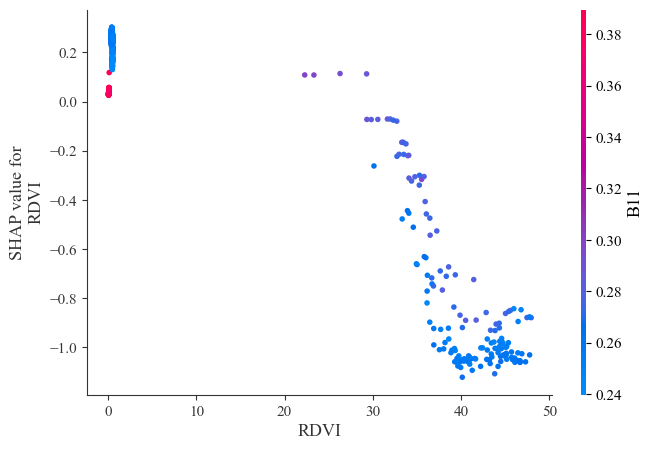

In [105]:
# 设置字体为新罗马并调整字体大小
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20  # 设置字体大小为14
# 创建 SHAP dependence plot，并修改配色方案为 'RdBu'
#shap.dependence_plot('nox', shap_values, data_train_x_nor1, interaction_index='dis', cmap='RdBu')
shap.dependence_plot('RDVI', shap_values, data_train_x_2, interaction_index='B11')#['VV','VVs','VH','VHs','NDVI','VHs/VVs']
plt.savefig('1.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# "DIS" 特征的影响分布：图中显示，较小的 "DIS" 值通常与 SHAP 值的负影响相关，即当 "DIS" 较小，即距离中心地区更近时，可能对模型预测产生降低影响。而 "DIS" 较大时，对模型预测的影响较小或无显著影响。
# 颜色的变化：红色点集中在 "DIS" 的中低值区域，可能表示在距离中心地区较近的地方，高税率对预测结果的负面影响更为显

In [116]:
#样本局部解释图
#设置全局字体大小  
plt.rcParams['font.size'] = 20  # 修改为你想要的大小  
# force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])
#force_plot1 = shap.force_plot(explainer.expected_value, shap_values[0,:], data_train_x_nor1.iloc[0,:],feature_label,matplotlib=True, show=False)

force_plot1 = shap.force_plot(explainer.expected_value, shap_values[25,:],data_test_x_2.iloc[25,:],feature_label,matplotlib=True, show=False)

# 显示图形

# 调整图形大小
# plt.gcf().set_size_inches(10, 8)

# 修改Xy轴标题  
#plt.ylabel(fontsize=30) 
#plt.xlabel(fontsize=30) 
# 设置字体为新罗马并调整字体大小

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20 # 设置字体大小为14 SimSun Times New Roman

# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(5)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in',width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=20)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=20)  # labelsize设置字体大小



# 保存图形为高质量的图片w()文件
plt.savefig('样本局部解释2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

# 这张图是 SHAP 的 force_plot，用于显示一个单一预测的详细特征贡献,每个特征对最终预测值的贡献以箭头的形式显示，箭头长度和颜色表示该特征的影响程度和方向

In [122]:
#样本局部解释图
#设置全局字体大小  
plt.rcParams['font.size'] = 20  # 修改为你想要的大小  
force_plot1 = shap.force_plot(explainer.expected_value, shap_values[25,:],data_test_x_2.iloc[25,:],feature_label,matplotlib=True, show=False)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20 # 设置字体大小为14 SimSun Times New Roman
# 修改X轴和Y轴的颜色和线宽  
plt.gca().spines['bottom'].set_color('black')  # 设置X轴颜色为黑色  
plt.gca().spines['bottom'].set_linewidth(5)  # 设置X轴线宽为1.5  
plt.gca().spines['left'].set_color('black')  # 设置Y轴颜色为黑色  
plt.gca().spines['left'].set_linewidth(2)  # 设置Y轴线宽为1.5  
plt.tick_params(axis='x', direction='in',width=2)  # direction='in'表示向内 
plt.tick_params(axis='y', width=2)  # direction='in'表示向内 
# 调整Xy轴刻度字体字号大小  
plt.tick_params(axis='x', labelsize=20)  # labelsize设置字体大小
plt.tick_params(axis='y', labelsize=20)  # labelsize设置字体大小
# 保存图形为高质量的图片w()文件
plt.savefig('样本局部解释2.png', dpi=300, bbox_inches='tight', pad_inches=0.1)

SHAP值检查： [ 0.04415918  0.12200601  0.10128074  0.09494252 -0.00135354 -0.00356136
 -0.0208796  -0.18370229  0.14281418 -0.00495603]
是否存在正向影响： True


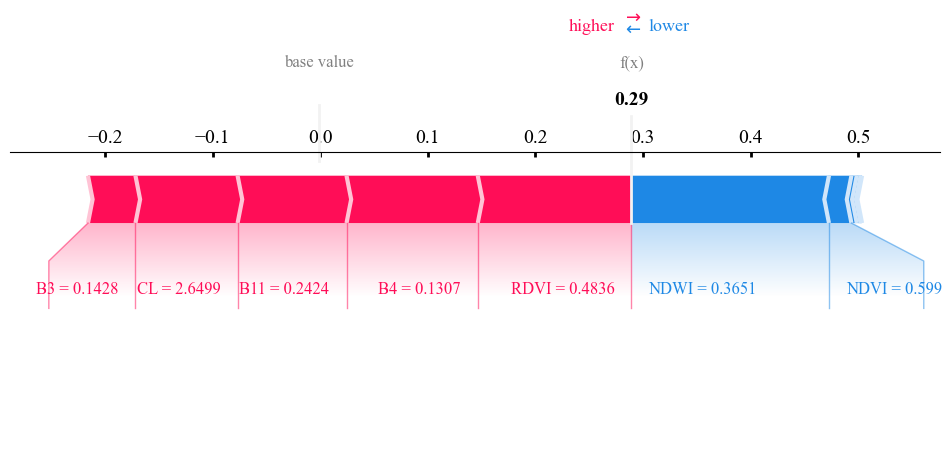

In [173]:
import matplotlib.pyplot as plt
import shap

x=400



# 1. 检查SHAP值
print("SHAP值检查：", shap_values[x, :])
print("是否存在正向影响：", any(shap_values[x, :] > 0))

# 2. 生成Force Plot
force_plot = shap.force_plot(
    explainer.expected_value,
    shap_values[x, :],
    #data_test_x_2.iloc[x, :],
    data_train_x_2.iloc[x, :],
    feature_label,
    matplotlib=True,
    show=False
)

# 3. 调整图形样式
fig = plt.gcf()
fig.set_size_inches(12, 4)  # 设置图像尺寸（宽度, 高度）

# 手动添加标题和标签（Force Plot默认无坐标轴标签）
#plt.title("SHAP Force Plot for Sample #25", fontsize=20, pad=20)
#plt.xlabel("Feature Impact on Prediction", fontsize=20, labelpad=10)

# 4. 坐标轴和刻度调整
ax = plt.gca()
ax.spines['bottom'].set_color('black')
ax.spines['bottom'].set_linewidth(5)
ax.spines['left'].set_color('black')
ax.spines['left'].set_linewidth(2)
ax.tick_params(axis='x', direction='in', width=2, labelsize=14)
ax.tick_params(axis='y', width=2, labelsize=16)

# 5. 保存图像
plt.savefig(
    '样本局部解释2.png',
    dpi=300,
    bbox_inches='tight',
    pad_inches=0.1,
    facecolor='white'  # 背景色
)
plt.show()

In [120]:
# force_plot = shap.force_plot(explainer.expected_value, shap_values[0], X_test.iloc[0, :])
force_plot1 = shap.force_plot(explainer.expected_value, np.mean(shap_values, axis=0), np.mean(data_test_x_2, axis=0
                                                                                              ),feature_label,matplotlib=True, show=False)

# 显示图形
# plt.show()
# 调整图形大小
# plt.gcf().set_size_inches(10, 8)
plt.show
# 保存图形为高质量的图片文件
plt.savefig('样本局部解释.png', dpi=300, bbox_inches='tight', pad_inches=0.1)


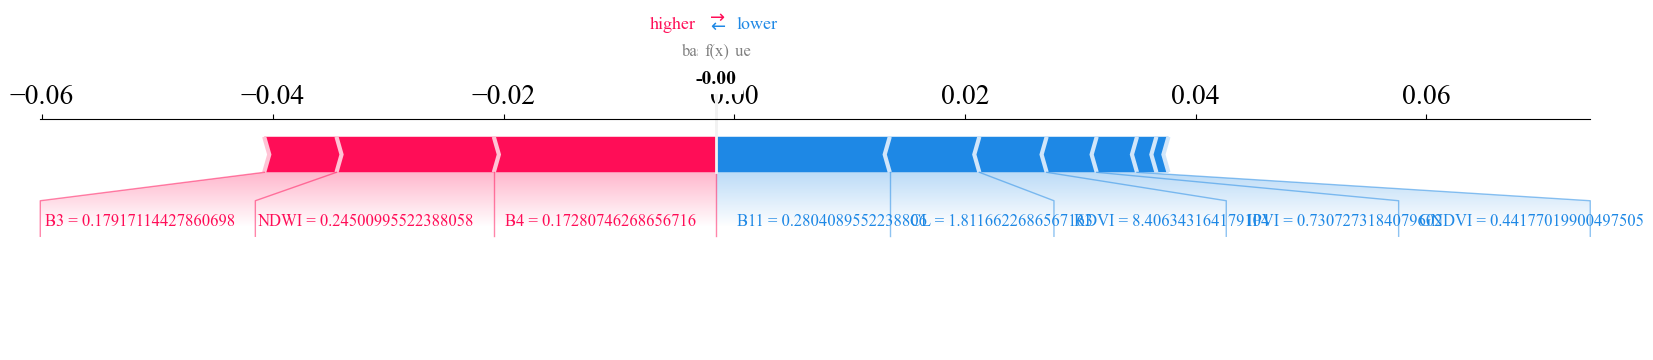

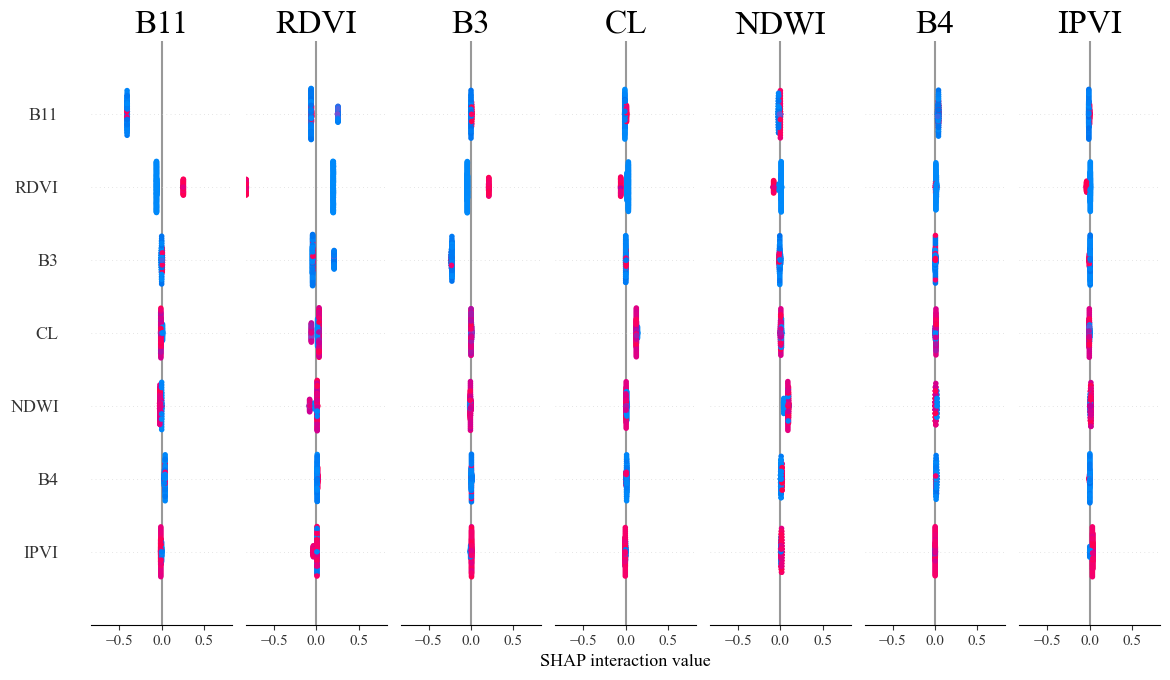

KeyboardInterrupt: 

In [121]:
#相互作用图
shap_interaction_values = explainer.shap_interaction_values(data_test_x_2)
shap.summary_plot(shap_interaction_values, data_test_x_2)
shap_interaction_values = explainer.shap_interaction_values(data_train_x_nor1)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.size'] = 20 # 设置字体大小为12
# 现在创建 SHAP 可视化
#配色   viridis  
# shap.summary_plot(shap_values, data_train_x_nor,feature_names=feature_label,cmap='Spectral',show=False)



# 修改全局配色方案
plt.set_cmap('viridis')  # 选择你喜欢的配色方案

# 绘制相互作用图
shap.summary_plot(shap_interaction_values, data_train_x_nor1, plot_type='dot', cmap='coolwarm',show=False)

plt.gcf().set_size_inches(7, 6)

# 保存图形为高质量的图片文件
plt.savefig('样本.png', dpi=300, bbox_inches='tight')

In [88]:

shap_values2 = explainer(data_train_x_nor1)
# 将 shap_values 转换为 DataFrame

# 绘制热力图

shap.plots.heatmap(shap_values2)

# 上侧是模型的输出，右侧是目标全局重要性

<Figure size 640x480 with 0 Axes>

<Axes: title={'center': 'IPVI'}, xlabel='Instances'>

In [165]:
import matplotlib.pyplot as plt
import shap
# 设置字体和颜色
# 获取当前图形的colorbar  

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 14,  # 改变字体大小
    'text.color': 'black',  # 修改文字颜色
    'axes.labelcolor': 'black',  # 修改轴标签颜色
    'xtick.color': 'black',  # 修改x轴刻度颜色
    'ytick.color': 'black'  # 修改y轴刻度颜色
})

plt.rcParams['font.size'] = 14  # 修改为你想要的大小  
# 确保 shap_values2 是 DataFrame 格式，并已正确计算
shap.plots.heatmap(shap_values2, cmap='RdBu')
fig = plt.gcf()
for ax in fig.axes:
    if hasattr(ax, 'images') and ax.images:  # 检查是否有图像层
        colorbar = ax.images[-1].colorbar
        if colorbar:
            colorbar.ax.tick_params(labelsize=88)  # 调整colorbar标签大小
            break
fig = plt.gcf()
axes = fig.get_axes()  # 获取所有坐标轴

# 3. 检查是否存在 colorbar 的坐标轴（通常为第二个坐标轴）
if len(axes) >= 2:
    colorbar_ax = axes[1]  # colorbar 通常位于第二个坐标轴
    colorbar_ax.tick_params(labelsize=30)  # 调整标签大小
else:
    print("未检测到 colorbar 坐标轴，请检查图形输出")


# 显示图表
plt.show()

plt.savefig('shap_heatmap.png', dpi=330, bbox_inches='tight')  # 高分辨率保存

未检测到 colorbar 坐标轴，请检查图形输出


<Figure size 640x480 with 0 Axes>